### Описание эксперимента
Перед вами таблица, где числовая переменная – непрерывная. Задача – сравнить группы двумя способами: бутстрапом и u-тестом

#### Описание колонок
value – значения метрики
experimentVariant – Вариант теста (Control – контроль, Treatment – тест)

### Задача
1. Сравните результат между тестом и контролем по двум кейсам:
 - Примените бутстрап (с np.mean) и критерий mann-whitney, а потом сравните p-value
 - Примените бутстрап (с np.median) и критерий mann-whitney, а потом сравните p-value.
2. Напишите выводы, которые можно сделать на основе анализа примененных критериев

In [1]:
import numpy as np
import pandas as pd
from scipy.stats import norm, mannwhitneyu, mode
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm.auto import tqdm
import seaborn as sns
plt.style.use('ggplot')

In [2]:
df=pd.read_csv('hw_bootstrap.csv', sep=';', index_col=0) # загрузка данных

In [3]:
df['value']=df.value.apply(lambda s: float(s.replace(',', '.'))) # приведение данных в нужный формат

In [4]:
# отберем данные по тестовой и контрольной группе
df_control=df.query('experimentVariant=="Control"')
df_test=df.query('experimentVariant=="Treatment"')

/opt/tljh/user/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


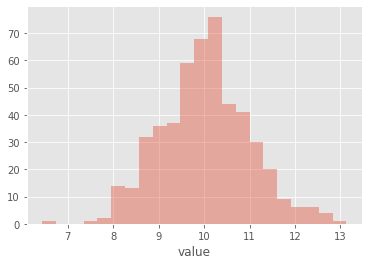

In [5]:
# посмотрим на распределение значений контрольной группы: нормально распределены
sns.distplot(df_control.value, kde=False)

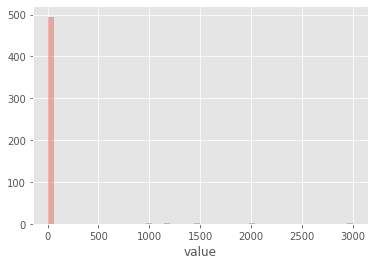

In [6]:
# посмотрим на распределение значений тестовой группы: распределение с выбросами
sns.distplot(df_test.value, kde=False)

In [7]:
# кол-во наблюдений в обоих группах (одинаковое)
num1, num2 = df_control.value.count(), df_test.value.count()
num1, num2

(500, 500)

### Таким образом для оценки отличий данных групп (test и control) мы не можем использовать t-test (в тестовой группе распределение не нормальное). Используем бутстрап и критерий mann-whitney.

In [46]:
# Объявим функцию, которая позволит проверять гипотезы с помощью бутстрапа
def get_bootstrap(
    data_column_1, # числовые значения первой выборки
    data_column_2, # числовые значения второй выборки
    boot_it, # количество бутстрэп-подвыборок
    statistic, # интересующая нас статистика
    bootstrap_conf_level # уровень значимости
):
    boot_len = max([len(data_column_1), len(data_column_2)])
    boot_data = []
    for i in tqdm(range(boot_it)): # извлекаем подвыборки
        samples_1 = data_column_1.sample(
            boot_len, 
            replace = True # параметр возвращения
        ).values
        
        samples_2 = data_column_2.sample(
            boot_len, 
            replace = True
        ).values
        
        boot_data.append(statistic(samples_1-samples_2)) #  применяем статистику
        
    pd_boot_data = pd.DataFrame(boot_data)
        
    left_quant = (1 - bootstrap_conf_level)/2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    ci = pd_boot_data.quantile([left_quant, right_quant])
        
    p_1 = norm.cdf(  # считаем вероятность того, что величина Х равна 0 в выборке со средним и отклонением как в полученной выборке
        x = 0, 
        loc = np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_2 = norm.cdf(
        x = 0, 
        loc = -np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2
        
    # Визуализация
    plt.hist(pd_boot_data[0], bins = 50)
    
    plt.style.use('ggplot')
    plt.vlines(ci,ymin=0,ymax=50,linestyle='--')
    plt.xlabel('boot_data')
    plt.ylabel('frequency')
    plt.title("Histogram of boot_data")
    plt.show()
       
    return {"boot_data": boot_data, 
            "ci": ci, 
            "p_value": p_value}

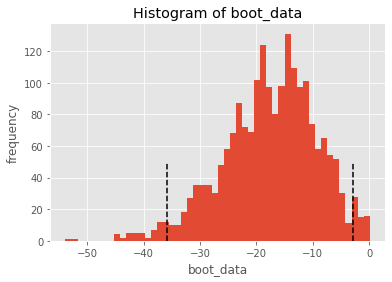

0.03417483015295661

In [63]:
get_bootstrap(df_control.value, df_test.value, 2000, np.mean, 0.95)['p_value']

Бутстрап по среднему: p_value < 0.05 и 0 не входит в доверительный интервал, отклоняем нулевую гипотезу о равенстве средних
в bootstrap-распределении. По средним делаем вывод, что значения для двух групп статистически отличаются

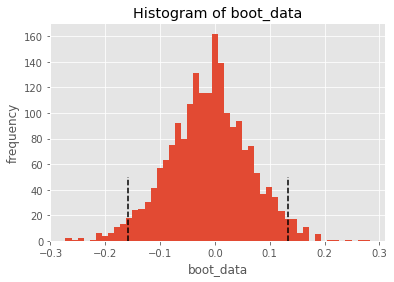

0.8883239289718726

In [65]:
get_bootstrap(df_control.value, df_test.value, 2000, np.median, 0.95)['p_value']

Бутстрап по медиане: p_value > 0.05, в доверительный интервал входит 0, значит у нас нет основания отклонять нулевую гипотезу
(о равенстве медиан в bootstrap-распределении). По медианам делаем вывод, что значения двух групп статистически не различаются

In [60]:
mannwhitneyu(df_control.value, df_test.value)

MannwhitneyuResult(statistic=124189.5, pvalue=0.8592148582485579)

Тест mann-whitney: p_value > 0.05 значит нулевая гипотеза о равенстве распределения выборок - верна. То есть значения 
двух групп статистически не отличаются

### Посмотрим, что изменится, если мы отсечем выбросы

In [73]:
df_test.value.describe()

count     500.000000
mean       27.321499
std       186.557011
min         6.436541
25%         9.421968
50%        10.025847
75%        10.675721
max      3000.000000
Name: value, dtype: float64

In [81]:
df_test_new=df_test.query('value < 100')

/opt/tljh/user/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


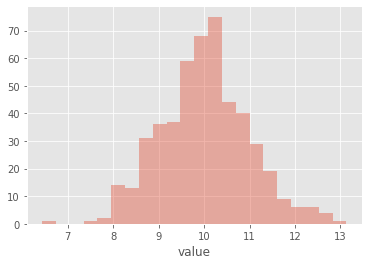

In [82]:
# посмотрим на распределение значений тестовой группы без выбросов: распределение с выбросами
sns.distplot(df_test_new.value, kde=False)

In [84]:
# кол-во наблюдений в обоих группах (практически одинаковое)
num1, num2 = df_control.value.count(), df_test_new.value.count()
num1, num2

(500, 495)

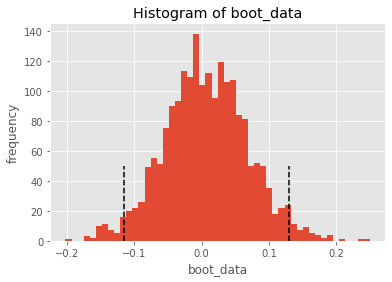

0.9130072237492132

In [85]:
get_bootstrap(df_control.value, df_test_new.value, 2000, np.mean, 0.95)['p_value']

Cнова проведем бутстрап по среднему: p_value > 0.05, в доверительный интервал входит 0, значит у нас нет основания отклонять
нулевую гипотезу (о равенстве средних в bootstrap-распределении). Делаем вывод, что значения двух групп статистически не
различаются 

### Итого
1. Тестовая выборка имеет большие выбросы, что сильно искажает нам среднее значение
2. Применяя бутстрап с оценкой среднего, мы могли бы отклонить нулевую гипотезу о равенстве средних и сделать вывод, что тестовая и контрольная выборка имеют различия
3. Однако, тот же бутстрап, но уже по медиане не дает нам отклонить нулевую гипотезу, так как p-value сильно больше 0.05, т.к. здесь проверяется другая гипотеза
4. U-критерий Манна-Уитни так же не дал бы нам отклонить нулевую гипотезу. Оценки pvalue так же направлены как у бутстрапирования медианы
5. Вывод: изменения НЕ выкатываем